# 自作のansatzを用いたVariational Quantum Eigensolver(VQE)

VQEで化学計算を行う際には、Hartree-Fock波動関数などの初期波動関数状態に対してユニタリ行列を演算させていきます。そして、演算させるユニタリ演算は使用するansatzによって決まります。
今回は自作したansatzを用いてVQEで水素分子の電子状態計算を行います。AnsatzはHardware Efficient Ansatz(HEA)を使用します。

必要なライブラリをインストールします。水素分子のハミルトニアンはOpenFermionで取得します。

In [ ]:
!pip3 install blueqat openfermion

必要なライブラリをインポートします。VQEの最適化はSciPyのminimizeで行います。

In [19]:
from blueqat import Circuit
from openfermion.hamiltonians import MolecularData
from openfermion.transforms import get_fermion_operator, jordan_wigner, get_sparse_operator
import numpy as np
from scipy.optimize import minimize

## Ansatzの定義
Ansatzを定義します。今回はHardware Efficient Ansatz（HEA）を使用します。HEAではまず初期化された各量子ビットにRy、Rzゲートを演算させ、その後隣接した量子ビット同士をCZゲートでつなぎます。そしてこのRy、Rz、CZゲートから構成されるブロックを複数回繰り返します（ただし文献によってゲートの種類やつなぎ方が微妙に異なります）。このansatzは物理的には、（RyとRzゲートによる）ブロッホ球上の回転を用いた各量子ビットの状態の変化と、（CZゲートを用いた）波動関数の探索空間の拡張との組み合わせと解釈できます。
引数はビット数n_qubitsとゲートの深さn_depthとしました。波動関数の初期化は関数内で行いました。

In [20]:
def HEA(params,n_qubits,n_depth):
    #波動関数初期化 |1100>
    circ=Circuit().x[2, 3]

    #量子回路作成
    params_devided=np.array_split(params,n_depth)
    for params_one_depth in params_devided:
        for i,param in enumerate(params_one_depth):
            if i < n_qubits:
                circ.ry(param)[i]
            else:
                circ.rz(param)[i%n_qubits]
        for qbit in range(n_qubits):
            if qbit < n_qubits-1:
                circ.cz[qbit,qbit+1]
    
    #量子回路実行
    wf = circ.run(backend="numpy")
    return wf

## 期待値とコスト関数
得られた波動関数から期待値を取得します。

In [21]:
def expect(wf,hamiltonian):
    return np.vdot(wf, hamiltonian.dot(wf)).real

def cost(params,hamiltonian,n_qubits,n_depth):
    wf=HEA(params,n_qubits,n_depth)
    return expect(wf,hamiltonian)

## 分子の情報取得
水素の結合長を指定し、OpenFermionを用いて分子の情報を取得します。基底関数はSTO-3Gです。

In [22]:
def get_molecule(length):
    geometry = [('H',(0.,0.,0.)),('H',(0.,0.,length))]
    try:
        description = f'{length:.2f}'
        molecule = MolecularData(geometry, "sto-3g",1,description=description)
        molecule.load()
    except:
        description = f'{length:.1f}'
        molecule = MolecularData(geometry, "sto-3g",1,description=description)
        molecule.load()
    return molecule

## 計算実行とプロット
各結合長でVQEを実行します(数分かかります)。その後、エネルギーと結合長に関してVQEとfull CI(FCI)の計算結果を比較します。

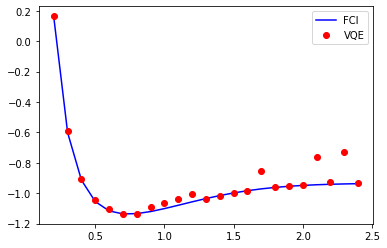

In [23]:
#結合長、HEA、FCIの結果記録用
bond_len_list = [];energy_list=[];fullci_list=[]
#各結合長で計算実行
for bond_len in np.arange(0.2,2.5,0.1):
    molecule = get_molecule(bond_len)
    #ビット数、深さ、パラメーター初期値を決める
    n_qubits=molecule.n_qubits
    n_depth=4
    init_params=np.random.rand(2*n_qubits*n_depth)*0.1
    #ハミルトニアン定義
    hamiltonian = get_sparse_operator(jordan_wigner(get_fermion_operator(molecule.get_molecular_hamiltonian())))
    #最適化実行
    result=minimize(cost,x0=init_params,args=(hamiltonian,n_qubits,n_depth))
    #結合長、HEA、FCIの結果記録
    bond_len_list.append(bond_len)
    energy_list.append(result.fun)
    fullci_list.append(molecule.fci_energy)

#プロット
import matplotlib.pyplot as plt
plt.plot(bond_len_list,fullci_list,label="FCI",color="blue")
plt.plot(bond_len_list,energy_list, marker="o",label="VQE",color="red",linestyle='None')
plt.legend()

初期パラメーターにもよりますが、結合長が大きいところではFCIとずれる傾向があります。この理由は結合長が大きくなるにつれ、用意した初期波動関数が真の解から離れていくためだと思われます。
初期パラメーターやansatz等を変更することで精度を改善できるため、いろいろなパターンで試してみると良いかもしれません。